# Fill the gap between ML+ZBL and Gaussian by optimizing parameters on ZBL potential

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os

from create_input.lmp.info_from_lmp_out import LammpsLogParser
from scf.qelattice import get_qel
from mlptools.utils.constants import ZERO_POINT_ENERGY

from mlptools.io.read import read_from_format

def get_two_body_result(path2root):
    pathes = glob(f'{path2root}/tb*')
    pathes.sort()
    result = []
    for path in pathes:
        try:
            r_from_path = float(path.split('/')[-1].split('_')[-1])
            obj = LammpsLogParser(path2target=path, dump_filename='dump.out')
            energy = obj.get_energy()
            result.append([r_from_path, energy])
        except:
            print(path)
            continue
    return np.array(result)

def plot_two_body(result, label, ax, color=None):
    # ax.plot(result[:,0], result[:,1], label=label, lw=2, marker='o')
    if color is None:
        ax.plot(result[:,0], result[:,1], label=label, lw=2, marker='o', markersize=2)
    else:
        ax.plot(result[:,0], result[:,1], label=label, lw=2, marker='o', markersize=2, color=color)

In [59]:
import seaborn as sns
class ZBL:
    p = 0.23
    # angstrom
    a0 = 0.46850
    c = [0.02817, 0.28022, 0.50986, 0.18175]
    d = [0.20162, 0.40290, 0.94229, 3.19980]
        
    def __init__(self, zi, zj, rc, r1):
        self.zi = zi
        self.zj = zj
        self.rc = rc
        self.r1 = r1
        
        # e * e / (4 * pi * epsilon_0) / electron_volt / angstrom
        self.zzeij = 14.399645478425668 * self.zi * self.zj  # eV.angstrom
        self.a = self.a0 / (zi ** self.p + zj ** self.p)
        self.da = [dl / self.a for dl in self.d]
        
        # switching function
        ec = self._e_zbl(self.rc)
        dec = self._dedr(self.rc)
        d2ec = self._d2edr2(self.rc)
        # coefficients are determined such that E(rc) = 0, E'(rc) = 0, and E''(rc) = 0
        self.A = (-3 * dec + (self.rc - self.r1) * d2ec) / ((self.rc - self.r1) ** 2)
        self.B = (2 * dec - (self.rc - self.r1) * d2ec) / ((self.rc - self.r1) ** 3)
        self.C = -ec + (self.rc - self.r1) * dec / 2 - ((self.rc - self.r1) ** 2) * d2ec / 12
        
    def _phi(self, r):
        phi = np.sum([cl * np.exp(-dal * r) for cl, dal in zip(self.c, self.da)])
        return phi
    
    def _dphi(self, r):
        dphi = np.sum([-cl * dal * np.exp(-dal * r) for cl, dal in zip(self.c, self.da)])
        return dphi
        
    def _e_zbl(self, r):
        phi = self._phi(r)
        ret = self.zzeij / r * phi
        return ret
    
    def _dedr(self, r):
        phi = self._phi(r)
        dphi = self._dphi(r)
        ret = self.zzeij / r * (-phi / r + dphi)
        return ret
    
    def _d2edr2(self, r):
        phi = self._phi(r)
        dphi = self._dphi(r)
        d2phi = np.sum([cl * (dal ** 2) * np.exp(-dal * r) for cl, dal in zip(self.c, self.da)])
        ret = self.zzeij / r * (d2phi - 2 / r * dphi + 2 * phi / (r ** 2))
        return ret
    
    def energy(self, r):
        if r > self.rc:
            return 0
        
        e = self._e_zbl(r)
        if r < self.r1:
            e += self.C
        else:
            e += self.A / 3 * ((r - self.r1) ** 3) + self.B / 4 * ((r - self.r1) ** 4) + self.C
        return e

In [60]:
path2root = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/ml-zbl/model_21'
result_ml_zbl = get_two_body_result(path2root)
result_ml_zbl[:, 1] = result_ml_zbl[:,1] - 2 * ZERO_POINT_ENERGY

path2root = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/ml/model_21'
result_ml = get_two_body_result(path2root)
result_ml[:, 1] = result_ml[:,1] - 2 * ZERO_POINT_ENERGY

path2root = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/two-body-potential/zbl/1.3'
result_zbl = get_two_body_result(path2root)

hartree2ev = 27.2114
ga_df = pd.read_csv('/Users/y1u0d2/desktop/Lab/result/gaussian/Si/distance_and_energy.csv')

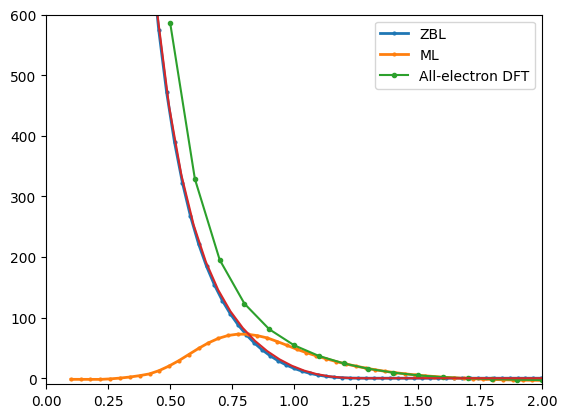

In [68]:
# plot
fig, ax = plt.subplots()

ax.plot(result_zbl[:, 0], result_zbl[:, 1], label='ZBL', lw=2, marker='o', markersize=2)
ax.plot(result_ml[:, 0], result_ml[:, 1], label='ML', lw=2, marker='o', markersize=2)
ax.plot(ga_df['distance'], ga_df['energy'] + 15740.401162, label='All-electron DFT', marker='o', markersize=3,)

rc = 1.3
r1 = 0.9
zbl = ZBL(14, 14, rc=rc, r1=r1)  # Ne-Ne
rs = np.linspace(0.1, 5.0, num=100, endpoint=True)
es = [zbl.energy(r) for r in rs]
ax.plot(rs, es)
ax.legend()

ax.set_xlim(0, 2.0)
ax.set_ylim(-10, 600)
plt.show()

In [72]:
ml_df = pd.DataFrame(result_ml, columns=['distance', 'energy'])

In [75]:
r1 = 1.0
rc_list = np.linspace(1.3, 2.0, num=11)
rc_list = np.round(rc_list, 1)

for rc in rc_list:
    zbl = ZBL(14, 14, rc=rc, r1=r1)
    zbl_val = ml_df['distance'].apply(lambda x: zbl.energy(x))
    ml_df[f'ML+ZBL_{rc}'] = ml_df['energy'] + zbl_val

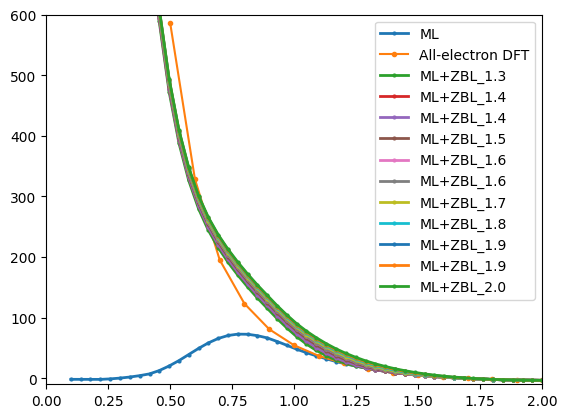

In [78]:
fig, ax = plt.subplots()
ax.plot(ml_df['distance'], ml_df['energy'], label='ML', lw=2, marker='o', markersize=2)
ax.plot(ga_df['distance'], ga_df['energy'] + 15740.401162, label='All-electron DFT', marker='o', markersize=3,)

for rc in rc_list:
    ax.plot(ml_df['distance'], ml_df[f'ML+ZBL_{rc}'], label=f'ML+ZBL_{rc}', lw=2, marker='o', markersize=2)

ax.set_xlim(0, 2.0)
ax.set_ylim(-10, 600)
ax.legend()